### RNN for weather prediction

#### 1. Pre Processing

In [599]:
import pandas as pd
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [600]:
outside_data = pd.read_csv("outside_weather_history.csv")

In [601]:
indoor_data  = pd.read_excel("indoor_temphumd_value.xlsx")

In [602]:
indoor_data.columns = indoor_data.iloc[0]

In [603]:
indoor_data.drop(indoor_data.index[0],inplace = True)

In [604]:
data = outside_data.copy()

In [605]:
data ['Indoor_Temperature'] = indoor_data["Temperatre "]
data ['Indoor_Humidity']    = indoor_data["Humidity"]

In [606]:
data.head()

Date time  Maximum Temperature  Minimum Temperature  Temperature  \
0  1/1/2019                 73.4                 59.7         66.9   
1  1/2/2019                 75.6                 62.0         68.3   
2  1/3/2019                 81.7                 65.5         72.5   
3  1/4/2019                 72.0                 58.9         66.1   
4  1/5/2019                 72.6                 53.6         61.6   

   Wind Chill  Heat Index  Precipitation  Snow Depth  Wind Speed  Wind Gust  \
0         NaN         NaN            0.0         NaN        11.1        NaN   
1         NaN         NaN            0.0         NaN        13.4        NaN   
2         NaN        80.7            0.0         NaN        24.4        NaN   
3         NaN         NaN            0.0         NaN        19.8        NaN   
4         NaN         NaN            0.0         NaN        16.4        NaN   

   Cloud Cover  Relative Humidity        Conditions Indoor_Temperature  \
0         21.4              71.24             Clear                NaN   
1         31.2              74.18  Partially cloudy                 20   
2          8.1              63.04             Clear               20.5   
3          1.0              57.22             Clear                 20   
4          0.5              64.74             Clear                 22   

  Indoor_Humidity  
0             NaN  
1              34  
2              30  
3              30  
4              35

In [607]:
data['Date time'] = pd.to_datetime(outside_data['Date time'])

In [608]:
data['year'] = pd.DatetimeIndex(outside_data['Date time']).year

In [609]:
data['month'] = pd.DatetimeIndex(outside_data['Date time']).month
data['day']   = pd.DatetimeIndex(outside_data['Date time']).day

In [610]:
data.isna().sum()

Date time                0
Maximum Temperature      3
Minimum Temperature      3
Temperature              3
Wind Chill             445
Heat Index             195
Precipitation            3
Snow Depth             455
Wind Speed               3
Wind Gust              456
Cloud Cover              3
Relative Humidity        3
Conditions               3
Indoor_Temperature       1
Indoor_Humidity          1
year                     0
month                    0
day                      0
dtype: int64

In [611]:
conditions = data["Conditions"]

In [612]:
data.drop(columns = ["Conditions"],inplace = True)

In [613]:
data.set_index('Date time',inplace = True)

In [614]:
data.interpolate(method='time', axis=0,inplace = True)

In [615]:
data.isna().sum()

Maximum Temperature      0
Minimum Temperature      0
Temperature              0
Wind Chill              19
Heat Index               2
Precipitation            0
Snow Depth             323
Wind Speed               0
Wind Gust              456
Cloud Cover              0
Relative Humidity        0
Indoor_Temperature       1
Indoor_Humidity          1
year                     0
month                    0
day                      0
dtype: int64

In [616]:
data.drop(columns = ["Wind Gust","Snow Depth","Precipitation"],inplace = True)

In [617]:
data.isna().sum()

Maximum Temperature     0
Minimum Temperature     0
Temperature             0
Wind Chill             19
Heat Index              2
Wind Speed              0
Cloud Cover             0
Relative Humidity       0
Indoor_Temperature      1
Indoor_Humidity         1
year                    0
month                   0
day                     0
dtype: int64

In [618]:
data.fillna(method = "bfill",inplace = True)

In [619]:
data.isna().sum()

Maximum Temperature    0
Minimum Temperature    0
Temperature            0
Wind Chill             0
Heat Index             0
Wind Speed             0
Cloud Cover            0
Relative Humidity      0
Indoor_Temperature     0
Indoor_Humidity        0
year                   0
month                  0
day                    0
dtype: int64

In [620]:
data.corr()

Maximum Temperature  Minimum Temperature  Temperature  \
Maximum Temperature             1.000000             0.949745     0.987301   
Minimum Temperature             0.949745             1.000000     0.983850   
Temperature                     0.987301             0.983850     1.000000   
Wind Chill                     -0.232261            -0.271353    -0.244474   
Heat Index                      0.932760             0.915532     0.933659   
Wind Speed                      0.061474             0.157583     0.114961   
Cloud Cover                    -0.348403            -0.191734    -0.277160   
Relative Humidity              -0.668558            -0.579139    -0.644352   
Indoor_Temperature              0.727340             0.700182     0.728478   
Indoor_Humidity                 0.704085             0.705883     0.717379   
year                           -0.461250            -0.485653    -0.475835   
month                           0.449649             0.482105     0.464466   
day                             0.000229            -0.009972    -0.006032   

                     Wind Chill  Heat Index  Wind Speed  Cloud Cover  \
Maximum Temperature   -0.232261    0.932760    0.061474    -0.348403   
Minimum Temperature   -0.271353    0.915532    0.157583    -0.191734   
Temperature           -0.244474    0.933659    0.114961    -0.277160   
Wind Chill             1.000000   -0.286620    0.110936     0.111604   
Heat Index            -0.286620    1.000000    0.030236    -0.341974   
Wind Speed             0.110936    0.030236    1.000000     0.170401   
Cloud Cover            0.111604   -0.341974    0.170401     1.000000   
Relative Humidity     -0.037971   -0.543523   -0.280153     0.437480   
Indoor_Temperature    -0.028745    0.703713    0.148122    -0.236715   
Indoor_Humidity       -0.153605    0.664707    0.062488    -0.117057   
year                   0.585458   -0.431040    0.022915     0.073072   
month                 -0.639419    0.449861   -0.196541    -0.101713   
day                   -0.001663    0.011778   -0.116745    -0.039822   

                     Relative Humidity  Indoor_Temperature  Indoor_Humidity  \
Maximum Temperature          -0.668558            0.727340         0.704085   
Minimum Temperature          -0.579139            0.700182         0.705883   
Temperature                  -0.644352            0.728478         0.717379   
Wind Chill                   -0.037971           -0.028745        -0.153605   
Heat Index                   -0.543523            0.703713         0.664707   
Wind Speed                   -0.280153            0.148122         0.062488   
Cloud Cover                   0.437480           -0.236715        -0.117057   
Relative Humidity             1.000000           -0.572768        -0.524525   
Indoor_Temperature           -0.572768            1.000000         0.652136   
Indoor_Humidity              -0.524525            0.652136         1.000000   
year                          0.231692           -0.366382        -0.427606   
month                        -0.106095            0.275455         0.494436   
day                           0.087948            0.030152         0.006086   

                         year     month       day  
Maximum Temperature -0.461250  0.449649  0.000229  
Minimum Temperature -0.485653  0.482105 -0.009972  
Temperature         -0.475835  0.464466 -0.006032  
Wind Chill           0.585458 -0.639419 -0.001663  
Heat Index          -0.431040  0.449861  0.011778  
Wind Speed           0.022915 -0.196541 -0.116745  
Cloud Cover          0.073072 -0.101713 -0.039822  
Relative Humidity    0.231692 -0.106095  0.087948  
Indoor_Temperature  -0.366382  0.275455  0.030152  
Indoor_Humidity     -0.427606  0.494436  0.006086  
year                 1.000000 -0.503187 -0.001783  
month               -0.503187  1.000000  0.010032  
day                 -0.001783  0.010032  1.000000

In [621]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(data)
kmo_model

0.8061720833889591

In [622]:
from factor_analyzer import FactorAnalyzer

In [623]:
fa = FactorAnalyzer()
fa.fit(data)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([6.22965131e+00, 1.85776317e+00, 1.20964879e+00, 1.00023812e+00,
       8.00243719e-01, 5.32663372e-01, 4.80417245e-01, 3.40931069e-01,
       2.40802791e-01, 2.08901724e-01, 6.77932409e-02, 2.88190839e-02,
       2.12635929e-03])

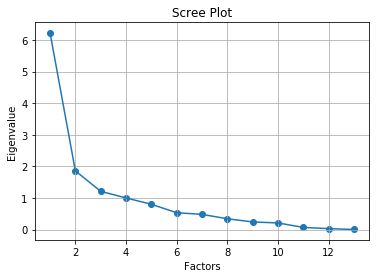

In [624]:
# Create scree plot using matplotlib
plt.scatter(range(1,data.shape[1]+1),ev)
plt.plot(range(1,data.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [625]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.set_params(n_factors=4, rotation="varimax")
fa.fit(data)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=4, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [626]:
factor_loadings = fa.loadings_

In [627]:
factor_loadings = pd.DataFrame(factor_loadings)

In [628]:
factor_loadings.set_index(data.columns,inplace = True)

In [629]:
factor_loadings

0         1         2         3
Maximum Temperature  0.946939  0.197169 -0.171338 -0.004141
Minimum Temperature  0.929066  0.257017 -0.008672  0.079069
Temperature          0.958307  0.218671 -0.094544  0.045099
Wind Chill          -0.010840 -0.998362  0.079884 -0.009024
Heat Index           0.883363  0.236476 -0.150894 -0.059792
Wind Speed           0.123329 -0.121587  0.091473  0.695660
Cloud Cover         -0.196819 -0.035128  0.966828  0.148695
Relative Humidity   -0.645455  0.067265  0.366438 -0.334721
Indoor_Temperature   0.773287  0.030493 -0.092003  0.082108
Indoor_Humidity      0.748817  0.190723  0.030616 -0.003690
year                -0.382380 -0.571430 -0.014411 -0.020812
month                0.368062  0.643221  0.041038 -0.231304
day                  0.005140 -0.007706 -0.004026 -0.175479

In [630]:
data.reset_index(drop = True,inplace = True)

In [631]:
data_2019 = data[data['year'] == 2019]

In [632]:
data_2020 = data[data['year'] == 2020]

In [673]:
y_train = data_2019[["Temperature","Relative Humidity","Indoor_Temperature","Indoor_Humidity"]]
X_train = data_2019[["Heat Index","Wind Chill","Cloud Cover","month"]].copy()
#X_train = data_2019.drop(columns = ["T,""emperature","Relative Humidity","Precipitation","Maximum Temperature","Minimum Temperature","Indoor_Temperature","Indoor_Humidity"])

In [674]:
y_test = data_2020[["Temperature","Relative Humidity","Indoor_Temperature","Indoor_Humidity"]]
X_test = data_2020[["Heat Index","Wind Chill","Cloud Cover","month"]].copy()

In [675]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
scaled_X_train = X_scaler.fit_transform(X_train)
scaled_X_test  = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
scaled_y_train = y_scaler.fit_transform(y_train)
#scaled_y_train = y_train.to_numpy()

#### 2. Creating Baseline RNN model

In [676]:
n_input = 4 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 1 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print(generator[0][0].shape)

(1, 4, 4)


In [677]:
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.1))
# Second LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))
# Fourth LSTM layer
model.add(LSTM(units=64))
model.add(Dropout(0.1))
#model.add(LSTM(64, return_sequences=False)) 
model.add(Dense(4))
model.compile(optimizer='adam', loss="mse")
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 4, 32)             4736      
_________________________________________________________________
lstm_67 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 260       
Total params: 29,828
Trainable params: 29,828
Non-trainable params: 0
_________________________________________________________________


In [678]:
model.fit_generator(generator,epochs=200)

Epoch 1/200
361/361 [==============================] - 2s 7ms/step - loss: 0.0552
Epoch 2/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0260
Epoch 3/200
361/361 [==============================] - ETA: 0s - loss: 0.024 - 2s 4ms/step - loss: 0.0243
Epoch 4/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0234
Epoch 5/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0239
Epoch 6/200
361/361 [==============================] - 1s 4ms/step - loss: 0.0221
Epoch 7/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0217
Epoch 8/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0216
Epoch 9/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0206
Epoch 10/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0211
Epoch 11/200
361/361 [==============================] - 2s 4ms/step - loss: 0.0209
Epoch 12/200
361/361 [==============================] - 2s 4ms/step - lo

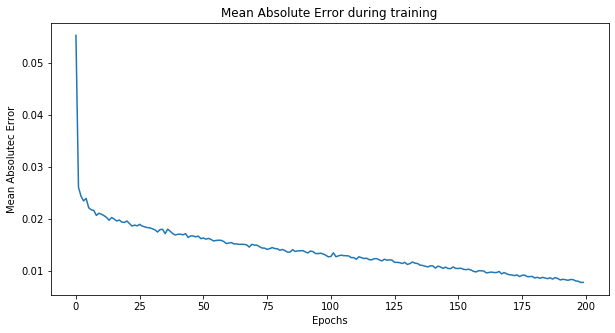

In [679]:
loss_per_epoch = model.history.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);
plt.xlabel('Epochs')
plt.ylabel('Mean Absolutec Error')
plt.title('Mean Absolute Error during training')

plt.show()

#### 3. Model Evaluation

##### Outdoor Temprature and Humidity

In [680]:
temp = pd.concat([(X_train.iloc[(len(X_train)-n_input):len(X_train),:]),X_test],axis = 0)

In [681]:
temp.reset_index(drop = True,inplace = True)

In [683]:
scaled_X_test =  X_scaler.transform(temp)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros((len(temp),4)), length=n_input, batch_size=b_size)
print(test_generator[0][0].shape)

(1, 4, 4)


In [684]:
y_pred = model.predict(test_generator)

In [685]:
y_pred = y_scaler.inverse_transform(y_pred)

In [692]:
y_test['Pred_Outdoor_Temp'] = list(y_pred[:,0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [693]:
y_test['Pred_Outdoor_Humi'] = y_pred[:,1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [694]:
y_test['Pred_Indoor_Temp'] = list(y_pred[:,2])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [695]:
y_test['Pred_Indoor_Humi'] = list(y_pred[:,3])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


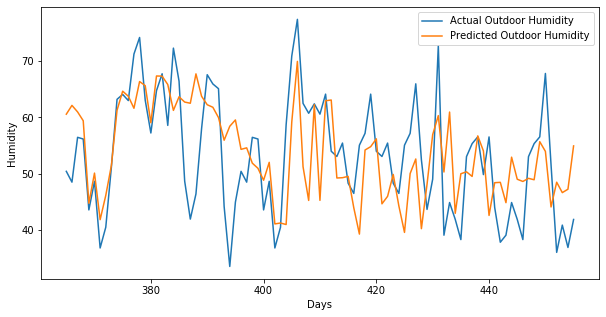

In [671]:
plt.figure(figsize=(10,5))
plt.plot(y_test[['Relative Humidity','Pred_Outdoor_Humi']])
plt.xlabel('Days')
plt.ylabel('Humidity')
plt.gca().legend(('Actual Outdoor Humidity','Predicted Outdoor Humidity'))
plt.show()

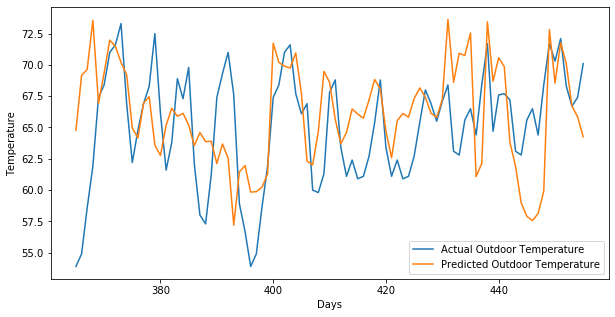

In [661]:
plt.figure(figsize=(10,5))
plt.plot(y_test[['Temperature','Pred_Outdoor_Temp']])
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.gca().legend(('Actual Outdoor Temperature','Predicted Outdoor Temperature'))
plt.show()

#### Indoor Temperature and Humidity

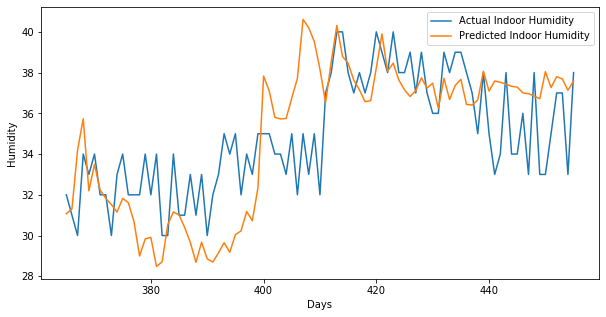

In [697]:
plt.figure(figsize=(10,5))
plt.plot(y_test[['Indoor_Humidity','Pred_Indoor_Humi']])
plt.xlabel('Days')
plt.ylabel('Humidity')
plt.gca().legend(('Actual Indoor Humidity','Predicted Indoor Humidity'))
plt.show()

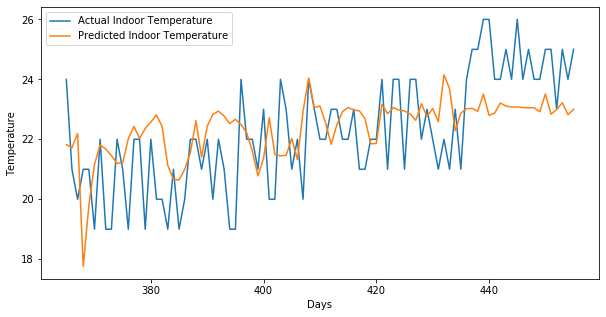

In [698]:
plt.figure(figsize=(10,5))
plt.plot(y_test[['Indoor_Temperature','Pred_Indoor_Temp']])
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.gca().legend(('Actual Indoor Temperature','Predicted Indoor Temperature'))
plt.show()

#### 4. Creating Output Files

In [702]:
data_2020.reset_index(drop = True,inplace = True)

In [709]:
data_2020["Pred_Outside_Temp"] = list(y_test["Pred_Outdoor_Temp"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [711]:
data_2020["Pred_Outside_Humidity"] = list(y_test["Pred_Outdoor_Humi"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [712]:
data_2020["Pred_Indoor_Humidity"] = list(y_test["Pred_Indoor_Humi"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [713]:
data_2020["Pred_Indoor_Temp"] = list(y_test["Pred_Indoor_Temp"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [715]:
data_2020.to_csv("Results_for_year_2020.csv")